# CLUSTER PROGRAMA FORMACIÓN DOCENTE EN SERVICIO 2023

In [120]:
#Librerias Usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings("ignore") 

import datetime 
import pyodbc
import joblib 

## Data Source

In [121]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_BA',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [122]:
#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT * 
            FROM [dbo].[MON_Transaccional_Preguntas] 
            WHERE COURSE_ID IN ('5') """

df = pd.read_sql_query(query1,conn)

In [123]:
df.head()

,COURSE_ID,COURSE_NOMBRE_CURSO,COURSE_FECHA_INICIO,QUIZ_CUESTIONARIO,QUIZ_INTENTOS_PERMITIDOS,QUIZ_MAXIMA_NOTA,QUIZ_ATTEMPTS_INTENTOS_USUARIO,QUIZ_GRADES_ULTIMA_NOTA,QUIZ_ATTEMPTS_FECHA_INICIO_CUEST,QUIZ_ATTEMPTS_FECHA_FIN_CUEST,USER_DNI,USER_NOMBRE,USER_APELLIDOS,USER_ENROLMENTS_FECHA_INICIO_CURSO
0,5,La convivencia democrática e intercultural en ...,2023-06-29 05:00:00,Cuestionario de entrada,1,20,1,6,2023-08-02 20:12:46,2023-08-02 20:16:44,75182688,JUNIOR,ORTIZ MEJIA,2023-07-12 05:00:00
1,5,La convivencia democrática e intercultural en ...,2023-06-29 05:00:00,Cuestionario de entrada,1,20,1,10,2023-07-18 23:46:51,2023-07-18 23:59:56,70802510,LILIANA,CAJA BUSTAMANTE,2023-06-30 05:00:00
2,5,La convivencia democrática e intercultural en ...,2023-06-29 05:00:00,Cuestionario de entrada,1,20,1,12,2023-07-11 04:37:51,2023-07-11 04:54:13,02890327,JUAN MIGUEL,SORALUZ UBILLUS,2023-06-30 05:00:00
3,5,La convivencia democrática e intercultural en ...,2023-06-29 05:00:00,Cuestionario de entrada,1,20,1,12,2023-07-27 14:12:10,2023-07-27 14:30:10,00370161,CLEMENTE LUIS,ARCE SAAVEDRA,2023-06-30 05:00:00
4,5,La convivencia democrática e intercultural en ...,2023-06-29 05:00:00,Cuestionario de entrada,1,20,1,16,2023-07-10 23:44:17,2023-07-11 00:29:17,76150280,YESICA ELIZABETH,MONTAÑEZ MILLA,2023-07-12 05:00:00


In [124]:
df_1=df[['COURSE_ID','USER_DNI','QUIZ_CUESTIONARIO','QUIZ_GRADES_ULTIMA_NOTA']]

In [125]:
df_table = pd.pivot_table(df_1, values='QUIZ_GRADES_ULTIMA_NOTA', columns=['QUIZ_CUESTIONARIO'], index=['COURSE_ID','USER_DNI'])

In [126]:
df_table.reset_index(inplace=True)

In [127]:
df_table.fillna(-1,inplace=True)

In [15]:
# data frame de observados que ya dieron su W1 2:Desarrollo Cuestionario antes de Cuestionario de Entrada
df_table[df_table['Cuestionario de entrada']==-1].shape

(64, 6)

In [128]:
valores = [-2, 0, 11,20]
cat = [-1,1,2]
df_table['CE']= pd.cut(df_table['Cuestionario de entrada'], bins=valores,labels=cat).astype('int')
df_table['CS']= pd.cut(df_table['Cuestionario de salida'], bins=valores,labels=cat).astype('int')
df_table['W12']= pd.cut(df_table['W1 2: Desarrollo Cuestionario'], bins=valores,labels=cat).astype('int')
df_table['W22']= pd.cut(df_table['W2 2: Desarrollo Cuestionario'], bins=valores,labels=cat).astype('int')

In [129]:
df_table.head()

QUIZ_CUESTIONARIO,COURSE_ID,USER_DNI,Cuestionario de entrada,Cuestionario de salida,W1 2: Desarrollo Cuestionario,W2 2: Desarrollo Cuestionario,CE,CS,W12,W22
0,5,00003749,12.0,-1.0,-1.0,-1.0,2,-1,-1,-1
1,5,00008251,16.0,-1.0,-1.0,-1.0,2,-1,-1,-1
2,5,00015479,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1
3,5,00015666,10.0,-1.0,-1.0,-1.0,1,-1,-1,-1
4,5,00015728,16.0,20.0,-1.0,-1.0,2,2,-1,-1


In [130]:
# función para buscar el optimó numero de codo
def grafico_codo(data_scaled):
  range_n_clusters = range(1, 11)
  inertias = []

  for n_clusters in range_n_clusters:
      modelo_kmeans = KMeans(n_clusters = n_clusters, n_init = 20, random_state = 123)
      modelo_kmeans.fit(X=data_scaled)
      inertias.append(modelo_kmeans.inertia_)

  fig, ax = plt.subplots(1, 1)
  ax.plot(range_n_clusters, inertias, marker='o')
  ax.set_title("Número Óptimo de Cluster")
  ax.set_xlabel('Número clusters')
  plt.show()

  # funcion para comparar el numero de cluster
def comparar_clusters(data_scaled):
   for i in range(3,7) :
    predicted_clusters_kmeans = KMeans(n_clusters=i, random_state=1).fit_predict(X=data_scaled)
    davies_bouldin_score_kmeans = davies_bouldin_score(data_scaled, predicted_clusters_kmeans)
    silhouette_score_kmeans = silhouette_score(data_scaled, predicted_clusters_kmeans)

    predicted_clusters_miniba = MiniBatchKMeans(n_clusters=i, random_state=2).fit_predict(X=data_scaled)
    davies_bouldin_score_miniba = davies_bouldin_score(data_scaled, predicted_clusters_miniba)
    silhouette_score_miniba = silhouette_score(data_scaled, predicted_clusters_miniba)

    result_comp_clusters = pd.DataFrame(index=['Índice de Davies-Bouldin', 'Índice de Silhouette'])
    result_comp_clusters['K-means'] = [davies_bouldin_score_kmeans, silhouette_score_kmeans]
    result_comp_clusters['MiniBatchKM'] = [davies_bouldin_score_miniba, silhouette_score_miniba]
    display(result_comp_clusters)


  # función para ver la correlacion de las variables
def plot_corr_v2(df):
    fig=plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(),annot=True)
    plt.tight_layout()

#Función grafico de cluster dos variables
def grafico_cluster_principal(datos, c1, c2):
  y = datos['clusters']
  plt.figure(figsize=(15, 15))
  fig, ax = plt.subplots()
  sc = ax.scatter(datos[c1], datos[c2],c=y)
  ax.legend(*sc.legend_elements(), title='Grupos')
  plt.xlabel(c1,size=14)
  plt.ylabel(c2,size=14)
  #plt.axis("equal")
  plt.title('Clusterización K-means(k=4)', size=18)
  plt.show()

# función para grafico de 3 variables 
def grafico_cluster_3d(datos,x,y,z):
  #definir colores 
  col = {1:'red',2:'blue',3:'green',4:'purple'}
  grupos = datos['clusters']
  fig = plt.figure(figsize=(14,12))
  ax = fig.add_subplot(111,projection='3d')
  ax.view_init(15, 40)
  plt.xlabel(x, size= 14)
  plt.ylabel(y, size= 14)
  plt.title("Clusterización K-means(k=4)",size= 20)
  plt.grid(True)
  sc = ax.scatter(datos[x],datos[y],datos[z],c=[col[group] for group in grupos])

      # Crear objetos de leyenda personalizados
  legend_labels = [f'Cluster {group}' for group in col.keys()]
  legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=col[group], markersize=10, label=label)
                      for group, label in zip(col.keys(), legend_labels)]
  
  # Agregar la leyenda al gráfico
  ax.legend(handles=legend_elements, title='Grupos', loc='upper right')
  plt.show()

In [131]:
df_table

QUIZ_CUESTIONARIO,COURSE_ID,USER_DNI,Cuestionario de entrada,Cuestionario de salida,W1 2: Desarrollo Cuestionario,W2 2: Desarrollo Cuestionario,CE,CS,W12,W22
0,5,00003749,12.0,-1.0,-1.0,-1.0,2,-1,-1,-1
1,5,00008251,16.0,-1.0,-1.0,-1.0,2,-1,-1,-1
2,5,00015479,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1
3,5,00015666,10.0,-1.0,-1.0,-1.0,1,-1,-1,-1
4,5,00015728,16.0,20.0,-1.0,-1.0,2,2,-1,-1
...,...,...,...,...,...,...,...,...,...,...
17793,5,80669017,4.0,-1.0,-1.0,-1.0,1,-1,-1,-1
17794,5,80670225,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1
17795,5,80670677,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1
17796,5,80671199,16.0,-1.0,-1.0,-1.0,2,-1,-1,-1


In [132]:
df_norm = StandardScaler().fit_transform(df_table.drop(['COURSE_ID','USER_DNI'],axis=1))

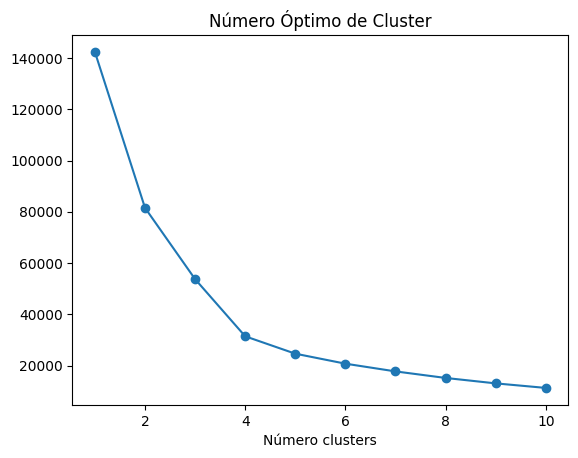

,K-means,MiniBatchKM
Índice de Davies-Bouldin,0.802399,0.786165
Índice de Silhouette,0.629211,0.611885


,K-means,MiniBatchKM
Índice de Davies-Bouldin,0.645086,0.611426
Índice de Silhouette,0.670496,0.663279


,K-means,MiniBatchKM
Índice de Davies-Bouldin,0.655609,0.655766
Índice de Silhouette,0.691783,0.691726


,K-means,MiniBatchKM
Índice de Davies-Bouldin,0.674184,0.646150
Índice de Silhouette,0.703862,0.650276


In [133]:
grafico_codo(df_norm)
comparar_clusters(df_norm)

In [134]:
df_norm

array([[-0.24363627, -0.44774234, -0.47662315, ..., -0.45200106,
        -0.49090688, -0.21243781],
       [ 0.88149043, -0.44774234, -0.47662315, ..., -0.45200106,
        -0.49090688, -0.21243781],
       [ 0.31892708, -0.44774234, -0.47662315, ..., -0.45200106,
        -0.49090688, -0.21243781],
       ...,
       [ 0.31892708, -0.44774234, -0.47662315, ..., -0.45200106,
        -0.49090688, -0.21243781],
       [ 0.88149043, -0.44774234, -0.47662315, ..., -0.45200106,
        -0.49090688, -0.21243781],
       [-0.80619962, -0.44774234, -0.47662315, ..., -0.45200106,
        -0.49090688, -0.21243781]])

In [135]:
#Asignación de Clustar 
kmeans = KMeans(n_clusters=4, random_state=123).fit(X=df_norm)
predicted_clusters_kmeans = kmeans.predict(df_norm)


In [136]:
#Calcular el centro de los grupos
kmeans.cluster_centers_

array([[ 0.4549517 , -0.44717195, -0.45728539, -0.20598715,  0.59759889,
        -0.45111555, -0.46707839, -0.210331  ],
       [ 0.26482263,  1.77461112,  1.7197296 , -0.20728363,  0.20077802,
         1.77941484,  1.73954384, -0.21243781],
       [ 0.11775269,  1.6432993 ,  1.83057623,  4.50651825,  0.03826908,
         1.67621946,  1.8999816 ,  4.5962526 ],
       [-1.27691181, -0.39086929, -0.36553105, -0.20295284, -1.56028694,
        -0.39065222, -0.36784925, -0.20575002]])

In [137]:
df_table['CLUSTER'] = predicted_clusters_kmeans + 1
df_table.groupby('CLUSTER')['USER_DNI'].count()

CLUSTER
1    10054
2     2745
3      776
4     4223
Name: USER_DNI, dtype: int64

In [140]:
#Exportar el modelo
joblib.dump(kmeans,"kmeans_cluster1.pkl")

['kmeans_cluster1.pkl']

In [141]:
df_res_g1=df_table[df_table['CLUSTER']==1]
df_res_g1.describe()

QUIZ_CUESTIONARIO,Cuestionario de entrada,Cuestionario de salida,W1 2: Desarrollo Cuestionario,W2 2: Desarrollo Cuestionario,CE,CS,W12,W22,CLUSTER
count,10054.000000,10054.000000,10054.000000,10054.000000,10054.0,10054.000000,10054.000000,10054.000000,10054.0
mean,14.483589,-0.995823,-0.868510,-0.993435,2.0,-0.999005,-0.973543,-0.998806,1.0
std,2.101872,0.219380,1.157031,0.268652,0.0,0.050846,0.228516,0.048846,0.0
min,12.000000,-1.000000,-1.000000,-1.000000,2.0,-1.000000,-1.000000,-1.000000,1.0
25%,12.000000,-1.000000,-1.000000,-1.000000,2.0,-1.000000,-1.000000,-1.000000,1.0
50%,14.000000,-1.000000,-1.000000,-1.000000,2.0,-1.000000,-1.000000,-1.000000,1.0
75%,16.000000,-1.000000,-1.000000,-1.000000,2.0,-1.000000,-1.000000,-1.000000,1.0
max,20.000000,12.000000,10.000000,10.000000,2.0,2.000000,1.000000,1.000000,1.0


In [142]:
df_res_g1=df_table[df_table['CLUSTER']==2]
df_res_g1.describe()

QUIZ_CUESTIONARIO,Cuestionario de entrada,Cuestionario de salida,W1 2: Desarrollo Cuestionario,W2 2: Desarrollo Cuestionario,CE,CS,W12,W22,CLUSTER
count,2745.00000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.0,2745.0
mean,13.80765,15.276138,13.934426,-0.997814,1.809836,1.506375,1.476503,-1.0,2.0
std,3.49523,7.500648,6.695376,0.046710,0.392502,1.107906,0.963006,0.0,0.0
min,2.00000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.0,2.0
25%,12.00000,14.000000,10.000000,-1.000000,2.000000,2.000000,1.000000,-1.0,2.0
50%,14.00000,20.000000,15.000000,-1.000000,2.000000,2.000000,2.000000,-1.0,2.0
75%,16.00000,20.000000,20.000000,-1.000000,2.000000,2.000000,2.000000,-1.0,2.0
max,20.00000,20.000000,20.000000,0.000000,2.000000,2.000000,2.000000,-1.0,2.0


In [143]:
df_res_g1=df_table[df_table['CLUSTER']==3]
df_res_g1.describe()

QUIZ_CUESTIONARIO,Cuestionario de entrada,Cuestionario de salida,W1 2: Desarrollo Cuestionario,W2 2: Desarrollo Cuestionario,CE,CS,W12,W22,CLUSTER
count,776.000000,776.000000,776.000000,776.00000,776.000000,776.000000,776.000000,776.000000,776.0
mean,13.284794,14.314433,14.688144,14.92268,1.731959,1.390464,1.654639,1.724227,3.0
std,3.733382,7.993003,5.140168,4.20374,0.468694,1.199295,0.635958,0.447191,0.0
min,-1.000000,-1.000000,-1.000000,5.00000,-1.000000,-1.000000,-1.000000,1.000000,3.0
25%,10.000000,14.000000,10.000000,10.00000,1.000000,2.000000,1.000000,1.000000,3.0
50%,14.000000,18.000000,15.000000,15.00000,2.000000,2.000000,2.000000,2.000000,3.0
75%,16.000000,20.000000,20.000000,20.00000,2.000000,2.000000,2.000000,2.000000,3.0
max,20.000000,20.000000,20.000000,20.00000,2.000000,2.000000,2.000000,2.000000,3.0


In [144]:
df_res_g1=df_table[df_table['CLUSTER']==4]
df_res_g1.describe()

QUIZ_CUESTIONARIO,Cuestionario de entrada,Cuestionario de salida,W1 2: Desarrollo Cuestionario,W2 2: Desarrollo Cuestionario,CE,CS,W12,W22,CLUSTER
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4223.0
mean,8.326545,-0.583471,-0.244613,-0.983187,0.965901,-0.931092,-0.863367,-0.996211,4.0
std,2.193542,2.742386,3.339339,0.386229,0.258942,0.444703,0.587281,0.086977,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.0
25%,8.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,4.0
50%,8.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,4.0
75%,10.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,4.0
max,10.000000,20.000000,20.000000,10.000000,1.000000,2.000000,2.000000,1.000000,4.0


In [145]:
df_table.rename({'QUIZ_CUESTIONARIO':'IDX','Cuestionario de entrada':'N_CE','Cuestionario de salida':'N_CS','W1 2: Desarrollo Cuestionario':'N_W12','W2 2: Desarrollo Cuestionario':'N_W22'}, axis=1 , inplace=True)

In [146]:
df_table['FECHA_REPORTE'] = datetime.datetime.now().date()
df_table

QUIZ_CUESTIONARIO,COURSE_ID,USER_DNI,N_CE,N_CS,N_W12,N_W22,CE,CS,W12,W22,CLUSTER,FECHA_REPORTE
0,5,00003749,12.0,-1.0,-1.0,-1.0,2,-1,-1,-1,1,2023-08-13
1,5,00008251,16.0,-1.0,-1.0,-1.0,2,-1,-1,-1,1,2023-08-13
2,5,00015479,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1,1,2023-08-13
3,5,00015666,10.0,-1.0,-1.0,-1.0,1,-1,-1,-1,4,2023-08-13
4,5,00015728,16.0,20.0,-1.0,-1.0,2,2,-1,-1,2,2023-08-13
...,...,...,...,...,...,...,...,...,...,...,...,...
17793,5,80669017,4.0,-1.0,-1.0,-1.0,1,-1,-1,-1,4,2023-08-13
17794,5,80670225,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1,1,2023-08-13
17795,5,80670677,14.0,-1.0,-1.0,-1.0,2,-1,-1,-1,1,2023-08-13
17796,5,80671199,16.0,-1.0,-1.0,-1.0,2,-1,-1,-1,1,2023-08-13


## Carga de Datos

In [147]:
conn3 = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_BA',
                      UID = 'usconsulta',
                      PWD = 'consulta')
cursor = conn3.cursor()
cursor.fast_executemany = True
# Borrar los datos de la tabla ml.cluste_2022
cursor.execute("TRUNCATE TABLE ml.docentes_cluster_pnfds")
conn3.commit()

In [148]:
# Insertar valores
sql_insert = """INSERT INTO ml.docentes_cluster_pnfds VALUES (?,?,?,?,?,?,?,?,?,?,?,?)"""
val = df_table[['COURSE_ID', 'USER_DNI', 'N_CE','N_CS','N_W12','N_W22','CE','CS','W12','W22','CLUSTER','FECHA_REPORTE']].values.tolist()
cursor.fast_executemany = True
cursor.executemany(sql_insert, val)
conn3.commit()
# Cerrar las conexiones
conn3.close()